In [14]:
from matplotlib import image
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os

In [78]:
# give labels some values
rootdir = "./Dataset/PokemonData2/"
i=0;
name_to_number={}
number_to_name={}
for folder in os.listdir(rootdir):
    name_to_number[str(folder)]=i
    number_to_name[i]=str(folder)
    i+=1
print(name_to_number)
print(number_to_name)
no_of_classes=len(number_to_name)

{'Arbok': 0, 'Bulbasaur': 1, 'Charizard': 2, 'Ditto': 3, 'Pikachu': 4, 'Zubat': 5}
{0: 'Arbok', 1: 'Bulbasaur', 2: 'Charizard', 3: 'Ditto', 4: 'Pikachu', 5: 'Zubat'}


# Store images as numpy arrays

In [79]:
height=60
width=60
columns=3
no_of_features=height*width*columns
# no of features for one image=height*width*columns
"""
store all pixels of an image in list and also append the label in this list 
so the last element of this list is label
these lists of all images will be stored in data
"""
data=[] 
rootdir = "./Dataset/PokemonData2/"
for folder in os.listdir(rootdir):
    for file in os.listdir(rootdir+folder+"/"):
        name=rootdir+folder+"/"+file
        try:
            img=Image.open(name)
            img=img.convert('RGB')# from rgba to rgb conversion
            img=img.resize((width,height))
            label=name_to_number[str(folder)]
            a=np.array(img)
            l=a.flatten().tolist()
            l.append(label)
            data.append(l)
        except:
            pass

In [80]:
data=np.array(data)
print(data.shape)


(259, 10801)


In [81]:
# shuffle the dataset\
np.random.seed(0)# to obtain same shuffling each time
np.random.shuffle(data)

#distribute in training data and testing data
split=int(data.shape[0]*0.8)
x_train,y_train=data[0:split,:-1],data[0:split,-1]
x_test,y_test=data[split:,:-1],data[split:,-1]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)



(207, 10800) (207,)
(52, 10800) (52,)


In [82]:
x_test=x_test/255.0
x_train=x_train/255.0

# 3-layered Neural Network implementation
## WITHOUT regularization

In [48]:
def sigmoid(x):
    #sigmoid
    return 1/(1+np.exp(-x));
    #relu function
    y=x
    y[x<0]=0
    return y

def relu(x):
    #relu function
    y=x
    y[x<0]=0
    return y


def tan_inv(x):
    #tanh
    return np.tanh(x)

activations={'sigmoid':sigmoid,'relu':relu,'tanh':tan_inv}

def sigmoid_diff(x):
    # first differential of activation function
    #sigmoid:
    """
    sigmoid'(x)=sigmoid(x)*(1-sigmoid(x))
    """
    sig=sigmoid(x)
    return sig*(1-sig) # element wise multiplication
def relu_diff(x):
    # first differential of activation function
    #relu:
    y=x
    y[x<0]=0
    y[x>0]=1
    return y
def tanh_diff(x):
    # first differential of activation function
    #tanh
    y=tan_inv(x)
    return (1-np.square(y))
activations_differential={'sigmoid':sigmoid_diff,'relu':relu_diff,'tanh':tanh_diff}

def softmax(a):
    exp_a=np.exp(a)
    exp_sum=np.sum(exp_a,axis=1,keepdims=True)
    return exp_a/exp_sum


# In[113]:


class NeuralNetwork:
    def __init__(self,input_size,output_size,hidden,activation_function):
        model={}# dictionary
        """
        input layer--(W1,B1)-->layer1--(W2,B2)-->layer2--(W3,B3)-->output layer
        """
        
        # from input layer to layer 1
        model['W1']=np.random.randn(input_size,hidden[0])
        model['B1']=np.zeros((1,hidden[0]))
        
        # from layer 1 to layer 2
        model['W2']=np.random.randn(hidden[0],hidden[1])
        model['B2']=np.zeros((1,hidden[1]))
        
        # from  layer 2 to output layer
        model['W3']=np.random.randn(hidden[1],output_size)
        model['B3']=np.zeros((1,output_size))
        
        """
        for x in model:
            print(x,model[x].shape)
        """
        self.model=model
        self.activation=activations[activation_function]
        self.activation_diff=activations_differential[activation_function]
    def forward_propagation(self,X):
        """
        X--> Matrix of size m X n where m is the no of examples and n=input_size
        """
        model=self.model
        W1,W2,W3=model['W1'],model['W2'],model['W3']
        b1,b2,b3=model['B1'],model['B2'],model['B3']
        activation=self.activation
        
        z1=np.dot(X,W1)+b1
        a1=activation(z1)
        
        z2=np.dot(a1,W2)+b2
        a2=activation(z2)
        
        z3=np.dot(a2,W3)+b3
        a3=softmax(z3)
        #print(a3)
        #print(a3.sum(axis=1))
        self.activations=(a1,a2,a3,z1,z2,z3)
        return a3
        
    def backward_propagation(self,x,y,learning_rate=0.001):
        model=self.model
        W1,W2,W3=model['W1'],model['W2'],model['W3']
        b1,b2,b3=model['B1'],model['B2'],model['B3']
        (a1,a2,a3,z1,z2,z3)=self.activations
        activation_diff=self.activation_diff
        
        
        delta3=a3-y
        dw3=np.dot(a2.T,delta3)
        db3=np.sum(delta3,axis=0)
        
        
        delta2=np.dot(delta3,W3.T)*(activation_diff(z2))
        dw2=np.dot(a1.T,delta2)
        db2=np.sum(delta2,axis=0)
        
        
        delta1=np.dot(delta2,W2.T)*(activation_diff(z1))
        dw1=np.dot(x.T,delta1)
        db1=np.sum(delta1,axis=0)
        
        # update
        self.model["W3"]-=learning_rate*dw3
        self.model["B3"]-=learning_rate*db3
        
        self.model["W2"]-=learning_rate*dw2
        self.model["B2"]-=learning_rate*db2
        
        self.model["W1"]-=learning_rate*dw1
        self.model["B1"]-=learning_rate*db1
        


    def predict(self,x):
        y_=self.forward_propagation(x)
        return np.argmax(y_,axis=1);
    def summary(self):
        model=self.model
        W1,W2,W3=model['W1'],model['W2'],model['W3']
        print(W1,W2,W3)
        
    def loss(self,y_oht,y_):
        return -np.mean(y_oht*np.log(y_))
        
        

        


# In[114]:


# convert the simple labels into one hot vector
def convert_to_oht(y,no_of_classes):
    m=y.shape[0]
    y_oht=np.zeros((m,no_of_classes))
    y_oht[range(m),y]=1
    return y_oht

def train(model,X,y,no_of_classes,epochs=200,learning_rate=0.0001,logs=True):
    y_oht=convert_to_oht(y,no_of_classes)
    losses=[]
    for i in range(epochs):
        y_=model.forward_propagation(X)
        l=model.loss(y_oht,y_)
        losses.append(l)
        if(logs and i%10==0):
            print("Iteration {}, loss= {}".format(i,l))
        model.backward_propagation(X,y_oht,learning_rate)
    return losses

def visualize_decision_boundry(X,Y,model):
    # X is only two featured
    [x0_min,x1_min]=np.min(X,axis=0)
    [x0_max,x1_max]=np.max(X,axis=0)
    x0=np.linspace(x0_min,x0_max,100)
    x1=np.linspace(x1_min,x1_max,100)
    x0,x1=np.meshgrid(x0,x1)
    x=np.zeros((x0.shape[0]*x0.shape[1],2))
    x[:,0]=x0.reshape(-1)
    x[:,1]=x1.reshape(-1)
    y_=model.predict(x)
    print(x.shape)
    print(y_.shape)
    
    plt.scatter(x[:,0],x[:,1],c=y_,cmap=plt.get_cmap('Accent'))
    plt.scatter(X[:,0],X[:,1],c=Y,cmap=plt.get_cmap("rainbow"))
    

        
        

In [49]:
model=NeuralNetwork(input_size=no_of_features,output_size=no_of_classes,hidden=[100,50],activation_function='tanh')
losses=train(model,x_train,y_train,no_of_classes,400,0.0007,True)

Iteration 0, loss= 1.758831035531169
Iteration 10, loss= 0.39918453827847994
Iteration 20, loss= 0.2874238009107647
Iteration 30, loss= 0.22756723330224501
Iteration 40, loss= 0.17317663370767702
Iteration 50, loss= 0.153459006465914
Iteration 60, loss= 0.13569290556070238
Iteration 70, loss= 0.11793179669582772
Iteration 80, loss= 0.10979119280249264
Iteration 90, loss= 0.09871280719798474
Iteration 100, loss= 0.10801128139015824
Iteration 110, loss= 0.08833195867054108
Iteration 120, loss= 0.07991946676790522
Iteration 130, loss= 0.07528405131655758
Iteration 140, loss= 0.06962547478682009
Iteration 150, loss= 0.06567109814022484
Iteration 160, loss= 0.06222997914096162
Iteration 170, loss= 0.06244066106665526
Iteration 180, loss= 0.0626690940564206
Iteration 190, loss= 0.05544389953859712
Iteration 200, loss= 0.05114927300282142
Iteration 210, loss= 0.05062009740217231
Iteration 220, loss= 0.04808060715919975
Iteration 230, loss= 0.045303507377241835
Iteration 240, loss= 0.043800167

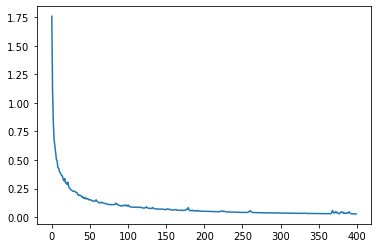

In [50]:
plt.plot(losses)

In [51]:
Y_=model.predict(x_train)

In [52]:
print(np.mean(Y_==y_train))

0.9631147540983607


In [53]:
Y_=model.predict(x_test)
print(np.mean(Y_==y_test))

0.3387096774193548


## Low efficiency??
Our efficiency is high on training set, but low on tetsing set.

This is due to ovefitting

Since we have a large no of parameteres, a very complex boundry is being developed by our neural network

To solve this we will do l2 regularization

# Regularized neural network
Use l2 regularization

reeference->https://www.youtube.com/watch?v=R0Dz8R0wgBs

https://github.com/Coding-Lane/L2-Regularization/blob/main/Solution%20-%20L2%20Regularization.ipynb

https://www.kaggle.com/mtax687/l2-regularization-of-neural-network-using-numpy/notebook

In [44]:
def sigmoid(x):
    #sigmoid
    return 1/(1+np.exp(-x));
    #relu function
    y=x
    y[x<0]=0
    return y

def relu(x):
    #relu function
    y=x
    y[x<0]=0
    return y


def tan_inv(x):
    #tanh
    return np.tanh(x)

activations={'sigmoid':sigmoid,'relu':relu,'tanh':tan_inv}

def sigmoid_diff(x):
    # first differential of activation function
    #sigmoid:
    """
    sigmoid'(x)=sigmoid(x)*(1-sigmoid(x))
    """
    sig=sigmoid(x)
    return sig*(1-sig) # element wise multiplication
def relu_diff(x):
    # first differential of activation function
    #relu:
    y=x
    y[x<0]=0
    y[x>0]=1
    return y
def tanh_diff(x):
    # first differential of activation function
    #tanh
    y=tan_inv(x)
    return (1-np.square(y))
activations_differential={'sigmoid':sigmoid_diff,'relu':relu_diff,'tanh':tanh_diff}

def softmax(a):
    exp_a=np.exp(a)
    exp_sum=np.sum(exp_a,axis=1,keepdims=True)
    return exp_a/exp_sum


# In[113]:


class NeuralNetwork:
    def __init__(self,input_size,output_size,hidden,activation_function):
        #np.random.seed(0)
        model={}# dictionary
        """
        input layer--(W1,B1)-->layer1--(W2,B2)-->layer2--(W3,B3)-->output layer
        """
        
        # from input layer to layer 1
        model['W1']=np.random.randn(input_size,hidden[0])
        model['B1']=np.zeros((1,hidden[0]))
        
        # from layer 1 to layer 2
        model['W2']=np.random.randn(hidden[0],hidden[1])
        model['B2']=np.zeros((1,hidden[1]))
        
        # from  layer 2 to output layer
        model['W3']=np.random.randn(hidden[1],output_size)
        model['B3']=np.zeros((1,output_size))
        
        """
        for x in model:
            print(x,model[x].shape)
        """
        self.model=model
        self.activation=activations[activation_function]
        self.activation_diff=activations_differential[activation_function]
    def forward_propagation(self,X):
        """
        X--> Matrix of size m X n where m is the no of examples and n=input_size
        """
        model=self.model
        W1,W2,W3=model['W1'],model['W2'],model['W3']
        b1,b2,b3=model['B1'],model['B2'],model['B3']
        activation=self.activation
        
        z1=np.dot(X,W1)+b1
        a1=activation(z1)
        
        z2=np.dot(a1,W2)+b2
        a2=activation(z2)
        
        z3=np.dot(a2,W3)+b3
        a3=softmax(z3)
        #print(a3)
        #print(a3.sum(axis=1))
        self.activations=(a1,a2,a3,z1,z2,z3)
        return a3
        
    def backward_propagation(self,x,y,learning_rate=0.001,lambd=0.5):
        # lambd is the regularization hyper-parameter
        model=self.model
        W1,W2,W3=model['W1'],model['W2'],model['W3']
        b1,b2,b3=model['B1'],model['B2'],model['B3']
        (a1,a2,a3,z1,z2,z3)=self.activations
        activation_diff=self.activation_diff
        
        m=x.shape[0]
        delta3=a3-y
        dw3=np.dot(a2.T,delta3)/m+(lambd/m)*(W3)
        db3=np.sum(delta3,axis=0)/m
        
        
        delta2=np.dot(delta3,W3.T)*(activation_diff(z2))
        dw2=np.dot(a1.T,delta2)/m+(lambd/m)*(W2)
        db2=np.sum(delta2,axis=0)/m
        
        
        delta1=np.dot(delta2,W2.T)*(activation_diff(z1))
        dw1=np.dot(x.T,delta1)/m+(lambd/m)*(W1)
        db1=np.sum(delta1,axis=0)/m
        
        # update
        self.model["W3"]-=learning_rate*dw3
        self.model["B3"]-=learning_rate*db3
        
        self.model["W2"]-=learning_rate*dw2
        self.model["B2"]-=learning_rate*db2
        
        self.model["W1"]-=learning_rate*dw1
        self.model["B1"]-=learning_rate*db1
        


    def predict(self,x):
        y_=self.forward_propagation(x)
        return np.argmax(y_,axis=1);
    def summary(self):
        model=self.model
        W1,W2,W3=model['W1'],model['W2'],model['W3']
        print(W1,W2,W3)
        
    def loss(self,y_oht,y_,lambd=0.5):
        m=y_.shape[0]
        W1,W2,W3=self.model['W1'],self.model['W2'],self.model['W3']
        regularization_loss=lambd*(np.sum(W1*W1)+np.sum(W2*W2)+np.sum(W3*W3))/(2*m)
        return -np.mean(y_oht*np.log(y_))+regularization_loss
        
        

        


# In[114]:


# convert the simple labels into one hot vector
def convert_to_oht(y,no_of_classes):
    m=y.shape[0]
    y_oht=np.zeros((m,no_of_classes))
    y_oht[range(m),y]=1
    return y_oht

def train(model,X,y,no_of_classes,epochs=200,learning_rate=0.0001,lambd=0.5,logs=True,*args):
    div=100
    if(len(args)>0):
        div=int(args[0])
    
    y_oht=convert_to_oht(y,no_of_classes)
    losses=[]
    for i in range(epochs):
        y_=model.forward_propagation(X)
        l=model.loss(y_oht,y_,lambd)
        losses.append(l)
        if(logs and i%div==0):
            print("Iteration {}, loss= {}".format(i,l))
        model.backward_propagation(X,y_oht,learning_rate,lambd)
    return losses

def visualize_decision_boundry(X,Y,model):
    # X is only two featured
    [x0_min,x1_min]=np.min(X,axis=0)
    [x0_max,x1_max]=np.max(X,axis=0)
    x0=np.linspace(x0_min,x0_max,100)
    x1=np.linspace(x1_min,x1_max,100)
    x0,x1=np.meshgrid(x0,x1)
    x=np.zeros((x0.shape[0]*x0.shape[1],2))
    x[:,0]=x0.reshape(-1)
    x[:,1]=x1.reshape(-1)
    y_=model.predict(x)
    print(x.shape)
    print(y_.shape)
    
    plt.scatter(x[:,0],x[:,1],c=y_,cmap=plt.get_cmap('Accent'))
    plt.scatter(X[:,0],X[:,1],c=Y,cmap=plt.get_cmap("rainbow"))
    

        
        

In [90]:

    model=NeuralNetwork(input_size=no_of_features,output_size=no_of_classes,hidden=[60,50],activation_function='sigmoid')
    losses=train(model,x_train,y_train,no_of_classes,5000,0.05,5,True,100)
    Y_=model.predict(x_train)
    print(np.mean(Y_==y_train))
    Y_=model.predict(x_test)
    print(np.mean(Y_==y_test))

Iteration 0, loss= 7856.161233569121
Iteration 100, loss= 6168.4653730138925
Iteration 200, loss= 4844.133098663668
Iteration 300, loss= 3804.171127780005
Iteration 400, loss= 2987.5068822091707
Iteration 500, loss= 2346.1902479796854
Iteration 600, loss= 1842.5747532336113
Iteration 700, loss= 1447.091888094233
Iteration 800, loss= 1136.5285667562134
Iteration 900, loss= 892.6504020492355
Iteration 1000, loss= 701.1345702218042
Iteration 1100, loss= 550.7419627852147
Iteration 1200, loss= 432.64145389189736
Iteration 1300, loss= 339.90020038702204
Iteration 1400, loss= 267.07216942050553
Iteration 1500, loss= 209.88128499345024
Iteration 1600, loss= 164.97065828486885
Iteration 1700, loss= 129.70407004917945
Iteration 1800, loss= 102.01056814626108
Iteration 1900, loss= 80.26452307062087
Iteration 2000, loss= 63.18910970798036
Iteration 2100, loss= 49.78125589988304
Iteration 2200, loss= 39.25336117817829
Iteration 2300, loss= 30.98689229770651
Iteration 2400, loss= 24.496042931815904

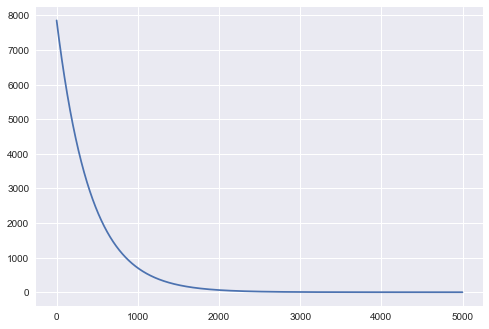

In [91]:
plt.style.use('seaborn')
plt.plot(losses)

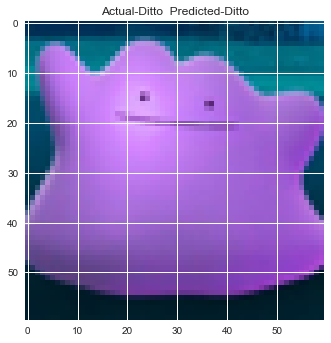

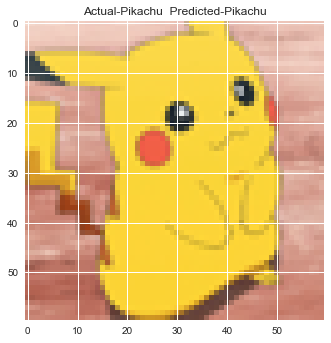

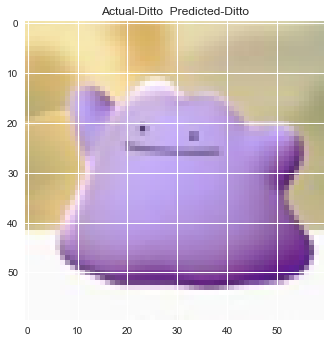

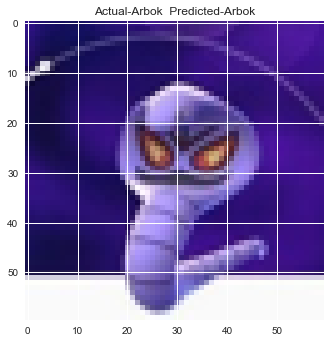

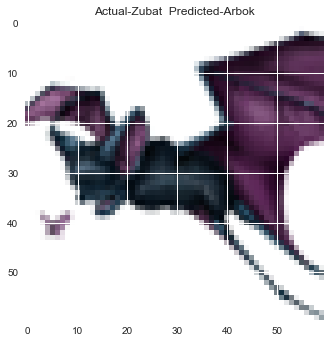

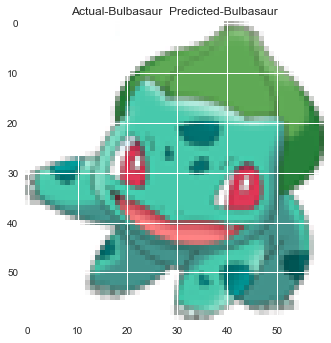

In [92]:
for i in range(x_test.shape[0]):
    if(i%10==0):
        arr=x_test[i]
        arr=arr.reshape((height,width,columns))
        plt.imshow(arr)
        plt.title("Actual-{}  Predicted-{}".format(number_to_name[y_test[i]],number_to_name[Y_[i]]))
        plt.show()

# precision and recall

In [116]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import seaborn as sns

In [96]:
y_test_predicted=model.predict(x_test)
y_train_predicted=model.predict(x_train)


              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         6
           3       0.75      1.00      0.86         6
           4       0.94      1.00      0.97        15
           5       1.00      0.50      0.67        10

    accuracy                           0.88        52
   macro avg       0.90      0.90      0.87        52
weighted avg       0.91      0.88      0.88        52



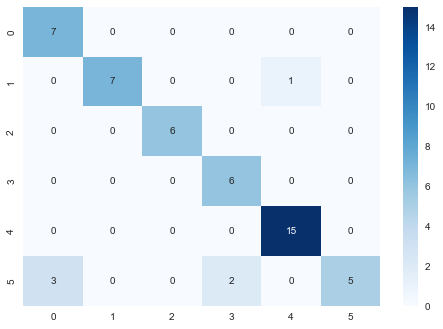

In [114]:
cm=confusion_matrix(y_test,y_test_predicted)
sns.heatmap(cm,annot=True,cmap='Blues')
print(classification_report(y_test,y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        29
           3       0.97      1.00      0.99        34
           4       1.00      1.00      1.00        47
           5       1.00      0.97      0.98        30

    accuracy                           1.00       207
   macro avg       1.00      0.99      0.99       207
weighted avg       1.00      1.00      1.00       207



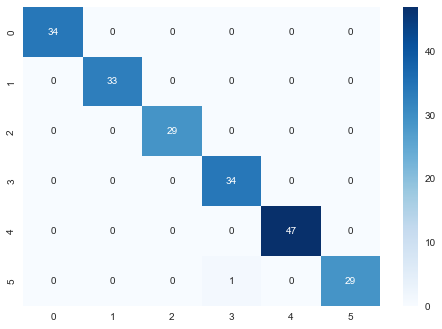

In [115]:
cm2=confusion_matrix(y_train,y_train_predicted)
sns.heatmap(cm2,annot=True,cmap='Blues')
print(classification_report(y_train,y_train_predicted))